In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %

This example was introduced in [BTV03] showing that there exists values of $\alpha$ for which the finiteness conjecture does not hold, that is, there is no $w = \sigma_1, \ldots, \sigma_k$ such that
$\sqrt[k]{\rho(A_{\sigma_k} \cdots A_{\sigma_1})}$ is equal to the JSR (such product is called a Spectral Maximizing Product (s.m.p.)).
Let $J_w \subseteq [0, 1]$ be the set of $\alpha$ such that $w$ is a s.m.p.
They show that for two words $u, v$ we have either $J_u = J_v$ (in which case $uuu\cdots$ and $vvv\cdots$ are identical up to a different prefix) or $J_u \cap J_v = \emptyset$.
In fact, let $\beta = \log(\alpha)$, since the function $h_w(\beta) = \log(\sqrt[|w|]{\rho(A_w)}) = \frac{1}{|w|}(\log(\rho(A_w)) + |w|_1 \beta)$ is affine in $\beta$, $J_u$ and $J_v$ can only be either equal, with empty intersection or with intersection equal to one of their two boundary points.
So [BTV03] excludes this last case.
The authors also mention that
$$ J_{0} = \{0\} \quad \text{ and } \quad J_1 = \emptyset. $$

In [Section V, GZ05], the authors show that
$$J_{10} = [4/5, 1] \quad \text{ and } \quad J_{100} \approx [0.5734, 0.7444]$$
The s.m.p. $10$ is not dominant for $\alpha = 4/5$ (see [Example 1, GP13]) but is dominant for $\alpha = 9/10$ (see [Example 2, GP13]).

It was then shown in [Section 6, GZ08] that for
$$J_{10010} =
\left[\frac{222924 - 23339 \sqrt{6}}{221184}, \frac{36864(222924 - 23339 \sqrt{6})}{7737809375} \right]
\approx [0.74940031328298342722, 0.789681582229248583974]$$

It was then proved in [HMST11] that the finiteness property does not hold for
$$\alpha = 0.749326546330367557943961948091344672091327370236064317358024...$$

[BTV03] V. D. Blondel, J. Theys and A. A. Vladimirov,
*An elementary counterexample to the finiteness conjecture*,
SIAM Journal on Matrix Analysis and Applications, **2003**. 24, 963-970.

[GP13] N. Guglielmi and V. Protasov.
*Exact computation of joint spectral characteristics of linear operators*.
Foundations of Computational Mathematics 13.1, **2013**, 37-97.

[GZ05] N. Guglielmi and M. Zennaro.
*Polytope norms and related algorithms for the computation of the joint spectral radius*.
44th IEEE Conference on Decision and Control, and European Control Conference, **2005**, pp. 3007-3012.

[GZ08] N. Guglielmi and M. Zennaro.
*An algorithm for finding extremal polytope norms of matrix families*.
Linear Algebra and its Applications, **2008**, 428(10), 2265-2282.

[HMST11] K. G. Hare, I. D Morris, N. Sidorov and J. Theys,
*An explicit counterexample to the Lagarias–Wang finiteness conjecture*.
Advances in Mathematics, **2011**, 226(6), 4667-4701.

# Defining the system

We start by defining the system using [HybridSystems](https://github.com/blegat/HybridSystems.jl) to represent the system and [StaticArrays](https://github.com/JuliaArrays/StaticArrays.jl) for an allocation-free representation of the matrices.

In [2]:
using HybridSystems
using StaticArrays
A0 = @SMatrix [1 1; 0 1]
A1 = @SMatrix [1 0; 1 1]
A(α) = discreteswitchedsystem([A0, α * A1])
s1 = A(1.0)

Hybrid System with automaton OneStateAutomaton(2)

We define a convenient printing function for printing the s.m.p. candidate we find. 

In [3]:
using SwitchOnSafety
strbin(s, bin::String) = periodicswitching(s, [HybridSystems.OneStateTransition(b - '0' + 1) for b in bin])
binstr(smp::SwitchOnSafety.DiscretePeriodicSwitching) = join(map(tr -> tr.σ - 1, smp.period))
function show_smp(smp)
    println("   SMP: ", binstr(smp))
    println("Length: ", length(smp.period))
    println("Growth: ", smp.growthrate)
end

show_smp (generic function with 1 method)

## $\alpha = 8/10$

For $\alpha = 8/10$, 10 is not a dominant s.m.p. but as the algorithm removes path lying on the boundary of the polytope, it still converges (see [Example 1, GP13]).

In [4]:
using GLPK
using SwitchOnSafety
s = A(0.8)
smp, done, polys = invariant_polytopes(s, with_optimizer(GLPK.Optimizer),
    SwitchOnSafety.periodicswitching(s, [2, 1]), tol=0.0, verbose=2);

v_1 = [0.850651, 0.525731]
v_2 = [0.470228, 0.760845]
Depth 1: [2] points, 2 living leaves...
Path starting starting at root 1: Int64[]:
1 : [0.951057, 0.363271] : living leaf: -0.10557280900008414 < 0.0

Path starting starting at root 2: Int64[]:
2 : [0.259936, 0.680521] : dead leaf: 0.11803398874989468 ≥ 0.0

Depth 2: [3] points, 1 living leaves...
Path starting starting at root 1: [1]:
1 : [0.908178, 0.251014] : dead leaf: 0.04721359549995796 ≥ 0.0

2 : [0.525731, 0.726543] : dead leaf: 0.0 ≥ 0.0

0 living leaves, PSW(1.447214, [2, 1]) is a spectral maximizing product (s.m.p.)
Use `tol` < -0.10557280900008414 to eliminite at least one more living leaf.
Use `tol` > 0.0 to keep at least one more dead leaf.


In [10]:
using GLPK
using SwitchOnSafety
s = A(0.8)
smp, done, polys = invariant_polytopes(s, with_optimizer(GLPK.Optimizer),
    SwitchOnSafety.periodicswitching(s, [2, 1]), tol=1e-15, verbose=2);

v_1 = [0.850651, 0.525731]
v_2 = [0.470228, 0.760845]
Depth 1: [2] points, 2 living leaves...
Path starting starting at root 1: Int64[]:
1 : [0.951057, 0.363271] : living leaf: -0.10557280900008414 < 1.0e-15

Path starting starting at root 2: Int64[]:
2 : [0.259936, 0.680521] : dead leaf: 0.11803398874989468 ≥ 1.0e-15

Depth 2: [3] points, 1 living leaves...
Path starting starting at root 1: [1]:
1 : [0.908178, 0.251014] : dead leaf: 0.04721359549995796 ≥ 1.0e-15

2 : [0.525731, 0.726543] : living leaf: 0.0 < 1.0e-15

Depth 3: [4] points, 1 living leaves...
Path starting starting at root 1: [2, 1]:
1 : [0.8653, 0.502029] : living leaf: 0.0 < 1.0e-15

2 : [0.290617, 0.69224] : dead leaf: 0.09910635852267946 ≥ 1.0e-15

Depth 4: [5] points, 1 living leaves...
Path starting starting at root 1: [1, 2, 1]:
1 : [0.944801, 0.346893] : dead leaf: 0.006621362806405129 ≥ 1.0e-15

2 : [0.478326, 0.755841] : living leaf: 2.220446049250313e-16 < 1.0e-15

Depth 5: [6] points, 1 living leaves...
Path 

In [11]:
using GLPK
using SwitchOnSafety
s = A(0.8)
smp, done, polys = invariant_polytopes(s, with_optimizer(GLPK.Optimizer),
    SwitchOnSafety.periodicswitching(s, [2, 1]), tol=1e-16, verbose=2);

v_1 = [0.850651, 0.525731]
v_2 = [0.470228, 0.760845]
Depth 1: [2] points, 2 living leaves...
Path starting starting at root 1: Int64[]:
1 : [0.951057, 0.363271] : living leaf: -0.10557280900008414 < 1.0e-16

Path starting starting at root 2: Int64[]:
2 : [0.259936, 0.680521] : dead leaf: 0.11803398874989468 ≥ 1.0e-16

Depth 2: [3] points, 1 living leaves...
Path starting starting at root 1: [1]:
1 : [0.908178, 0.251014] : dead leaf: 0.04721359549995796 ≥ 1.0e-16

2 : [0.525731, 0.726543] : living leaf: 0.0 < 1.0e-16

Depth 3: [4] points, 1 living leaves...
Path starting starting at root 1: [2, 1]:
1 : [0.8653, 0.502029] : living leaf: 0.0 < 1.0e-16

2 : [0.290617, 0.69224] : dead leaf: 0.09910635852267946 ≥ 1.0e-16

Depth 4: [5] points, 1 living leaves...
Path starting starting at root 1: [1, 2, 1]:
1 : [0.944801, 0.346893] : dead leaf: 0.006621362806405129 ≥ 1.0e-16

2 : [0.478326, 0.755841] : dead leaf: 2.220446049250313e-16 ≥ 1.0e-16

0 living leaves, PSW(1.447214, [2, 1]) is a spe

In [12]:
using GLPK
using SwitchOnSafety
s = A(0.8)
smp, done, polys = invariant_polytopes(s, with_optimizer(GLPK.Optimizer), SwitchOnSafety.periodicswitching(s, [2, 1]));

Depth 1: [2] points, 2 living leaves...
Depth 2: [3] points, 1 living leaves...
0 living leaves, PSW(1.447214, [2, 1]) is a spectral maximizing product (s.m.p.)
Use the `tol` keyword argument to change the threshold to evaluate dead and living leaves.


## $\alpha = 9/10$

For $\alpha = 9/10$, 10 is a dominant s.m.p. (see [Example 2, GP13]).

In [13]:
using GLPK
using SwitchOnSafety
s = A(0.9)
smp, done, polys = invariant_polytopes(s, with_optimizer(GLPK.Optimizer),
    SwitchOnSafety.periodicswitching(s, [2, 1]));

Depth 1: [2] points, 2 living leaves...
Depth 2: [3] points, 1 living leaves...
0 living leaves, PSW(1.535002, [2, 1]) is a spectral maximizing product (s.m.p.)
Use the `tol` keyword argument to change the threshold to evaluate dead and living leaves.


We can reproduce [Figure 2, GP13] below.

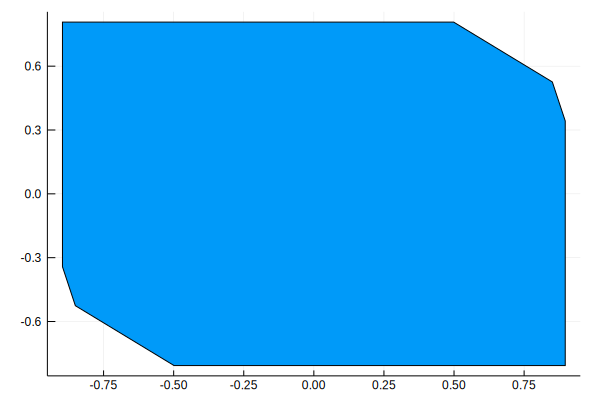

In [4]:
using Polyhedra
p = polyhedron(polys[1])
using Plots
plot(p)

# Getting close to non-finiteness

It was shown in [HMST11] that the finiteness conjecture does not hold for $\alpha = 0.749326546330367557943961948091344672091327370236064317358024$.
In a double-precision floating point number, the closest value we can represent is $\alpha = 0.7493265463303675$.
We create the switched system corresponding for this value of $\alpha$ and look for approximating the JSR for this value.

In [4]:
α∞ = 0.749326546330367557943961948091344672091327370236064317358024
@show significand(α∞)
@show exponent(α∞)
@show significand(α∞) / (1 << -exponent(α∞))
s∞ = A(α∞)

significand(α∞) = 1.498653092660735
exponent(α∞) = -1
significand(α∞) / (1 << -(exponent(α∞))) = 0.7493265463303675


Hybrid System with automaton OneStateAutomaton(2)

## Sum-of-Squares approach

We start with the Sum-of-Squares approach to have an idea of the value of the JSR.
We first choose an SDP solver.

In [5]:
using MosekTools
using JuMP
factory = with_optimizer(Mosek.Optimizer, QUIET=true);

In [28]:
using SwitchOnSafety
sos_lb = zeros(15)
sos_ub = zeros(15)
function sos(d, tol; kws...)
    # Prevents the binary search to use a lower bound found by a cycle
    # to have to full timing of the binary search
    sosdata(s∞).lb = 0.0
    # Force recomputing it to have correct timing even when the function called twice with the same d
    if length(sosdata(s∞).lyaps) >= d
        sosdata(s∞).lyaps[d] = nothing
    end
    println("   Degree d: ", d)
    @time sos_lb[d], sos_ub[d] = soslyapb(s∞, d; factory=factory, tol=tol, verbose=1, kws...)
end

sos (generic function with 1 method)

We start with degree $2d = 2$, i.e. the Common Quadratic Lyapunov Function (CQLF).

In [10]:
sos(1, 3e-8)

   Degree d: 1
Lower bound: 1.4264937578077195
Upper bound: 1.426493800391043
Log-diff   : 2.985174152314585e-8 ≤ 3.0e-8
  0.482680 seconds (269.12 k allocations: 16.531 MiB, 1.60% gc time)


(1.008683409466119, 1.426493800391043)

In [15]:
sos(1, 4e-8)

   Degree d: 1
Lower bound: 1.4264937524583678
Upper bound: 1.4264938090951405
Log-diff   : 3.9703483722952626e-8 ≤ 4.0e-8
  0.105495 seconds (136.87 k allocations: 12.054 MiB)


(1.008683405683556, 1.4264938090951405)

Using $l = 4$, the time taken to build the sequence is still neglibible to the time used to solve the SDP and the first 21 matrices of the sequence produces give a sequence of growth rate $1.4092$.

In [29]:
sos(1, 1e-2)

   Degree d: 1
Lower bound: 1.4167978996991486
Upper bound: 1.4279099833483804
Log-diff   : 0.007812500000000056 ≤ 0.01
  0.121544 seconds (67.11 k allocations: 4.281 MiB)


(1.001827402448126, 1.4279099833483804)

In [30]:
@time seq = sosbuildsequence(s∞, 1, niter=21, l=4, p_0=:Primal)
@time psw = findsmp(seq)
show_smp(psw)

  0.000502 seconds (7.29 k allocations: 426.719 KiB)
  0.000671 seconds (8.34 k allocations: 752.047 KiB)
   SMP: 010010100100101001001
Length: 21
Growth: 1.4092472220583487


With degree $2d = 4$, the upper bound gets closer to the lower bound given by the cycle of length 21 just found.

In [40]:
sos(2, 3e-8)

   Degree d: 2
Lower bound: 1.415875249771036
Upper bound: 1.4158752920373792
Log-diff   : 2.9851741911723906e-8 ≤ 3.0e-8
  0.484901 seconds (338.67 k allocations: 22.678 MiB, 1.31% gc time)


(1.190604421978922, 1.4158752920373792)

With $l=4$, we find the same cycle.

In [43]:
@time seq = sosbuildsequence(s∞, 2, niter=21, l=4, p_0=:Primal)
@time psw = findsmp(seq)
show_smp(psw)

  0.001424 seconds (11.43 k allocations: 714.375 KiB)
  0.001404 seconds (8.35 k allocations: 752.578 KiB)
   SMP: 010010100100101001001
Length: 21
Growth: 1.4092472220583487


We continue increasing the degree until $2d = 30$. The tolerance here were tuned by hand.

In [44]:
sos(3, 3e-7)

   Degree d: 3
Lower bound: 1.412829693184879
Upper bound: 1.4128299886223639
Log-diff   : 2.0911045078841894e-7 ≤ 3.0e-7
  0.453285 seconds (344.09 k allocations: 23.507 MiB, 1.38% gc time)


(1.2586881626090174, 1.4128299886223639)

In [45]:
sos(4, 7e-7)

   Degree d: 4
Lower bound: 1.4117969350593536
Upper bound: 1.4117978553213555
Log-diff   : 6.518371581387683e-7 ≤ 7.0e-7
  0.479464 seconds (444.09 k allocations: 32.152 MiB, 2.77% gc time)


(1.29462349763339, 1.4117978553213555)

In [46]:
sos(5, 2e-5)
@show sos_ub[5] - smp.growthrate

   Degree d: 5
Lower bound: 1.410248109626937
Upper bound: 1.4102733366296667
Log-diff   : 1.7888183593717244e-5 ≤ 2.0e-5
  0.695910 seconds (1.26 M allocations: 78.386 MiB, 3.33% gc time)
sos_ub[5] - smp.growthrate = 0.0010261145713179598


0.0010261145713179598

In [47]:
sos(6, 5e-5)
@show sos_ub[6] - smp.growthrate

   Degree d: 6
Lower bound: 1.4098195639947941
Upper bound: 1.4098879914681728
Log-diff   : 4.8535156250140155e-5 ≤ 5.0e-5
  0.473659 seconds (1.14 M allocations: 79.557 MiB, 5.51% gc time)
sos_ub[6] - smp.growthrate = 0.0006407694098240491


0.0006407694098240491

In [48]:
sos(7, 3e-5)
@show sos_ub[7] - smp.growthrate

   Degree d: 7
Lower bound: 1.409797216501079
Upper bound: 1.409836514586889
Log-diff   : 2.787460327147162e-5 ≤ 3.0e-5
  0.777881 seconds (1.93 M allocations: 137.653 MiB, 4.71% gc time)
sos_ub[7] - smp.growthrate = 0.0005892925285402306


0.0005892925285402306

In [49]:
sos(8, 5e-5)
@show sos_ub[8] - smp.growthrate

   Degree d: 8
Lower bound: 1.4097677292967568
Upper bound: 1.4098322648190718
Log-diff   : 4.57763671875e-5 ≤ 5.0e-5
  0.520423 seconds (2.10 M allocations: 144.471 MiB, 8.27% gc time)
sos_ub[8] - smp.growthrate = 0.0005850427607230202


0.0005850427607230202

In [50]:
sos(9, 5e-5)
@show sos_ub[9] - smp.growthrate

   Degree d: 9
Lower bound: 1.4097423289253832
Upper bound: 1.4098107526500547
Log-diff   : 4.8535156250140155e-5 ≤ 5.0e-5
  0.667288 seconds (3.23 M allocations: 213.821 MiB, 9.44% gc time)
sos_ub[9] - smp.growthrate = 0.0005635305917059963


0.0005635305917059963

In [51]:
sos(10, 4e-5)
@show sos_ub[10] - smp.growthrate

   Degree d: 10
Lower bound: 1.40975399651882
Upper bound: 1.409803703613914
Log-diff   : 3.525878906240898e-5 ≤ 4.0e-5
  0.980113 seconds (4.78 M allocations: 319.296 MiB, 8.56% gc time)
sos_ub[10] - smp.growthrate = 0.0005564815555652025


0.0005564815555652025

In [52]:
sos(11, 4e-5)
@show sos_ub[11] - smp.growthrate

   Degree d: 11
Lower bound: 1.4097395342241223
Upper bound: 1.4097892408092847
Log-diff   : 3.5258789062686535e-5 ≤ 4.0e-5
  1.116944 seconds (5.29 M allocations: 360.315 MiB, 9.07% gc time)
sos_ub[11] - smp.growthrate = 0.0005420187509359575


0.0005420187509359575

In [53]:
sos(12, 4e-5)
@show sos_ub[12] - smp.growthrate

   Degree d: 12
Lower bound: 1.4097391693989973
Upper bound: 1.4097888759712958
Log-diff   : 3.525878906235347e-5 ≤ 4.0e-5
  1.259871 seconds (7.24 M allocations: 465.759 MiB, 9.99% gc time)
sos_ub[12] - smp.growthrate = 0.0005416539129470266


0.0005416539129470266

In [54]:
sos(13, 21e-6)
@show sos_ub[13] - smp.growthrate

   Degree d: 13
Lower bound: 1.4097388169642486
Upper bound: 1.4097677292967568
Log-diff   : 2.0508789062734234e-5 ≤ 2.1e-5
  1.459461 seconds (9.93 M allocations: 600.301 MiB, 11.56% gc time)
sos_ub[13] - smp.growthrate = 0.0005205072384080189


0.0005205072384080189

In [55]:
sos(14, 21e-6)
@show sos_ub[14] - smp.growthrate

   Degree d: 14
Lower bound: 1.4097408403676797
Upper bound: 1.4097579921324812
Log-diff   : 1.2166534423818653e-5 ≤ 2.1e-5
  1.785501 seconds (10.65 M allocations: 669.105 MiB, 9.71% gc time)
sos_ub[14] - smp.growthrate = 0.0005107700741324717


0.0005107700741324717

In [32]:
sos(15, 20.2e-6)
@show sos_ub[15] - smp.growthrate

   Degree d: 15
Lower bound: 1.4097368070725529
Upper bound: 1.4097631455284172
Log-diff   : 1.8683068847558104e-5 ≤ 2.02e-5
  2.342687 seconds (16.02 M allocations: 993.005 MiB, 10.98% gc time)
sos_ub[15] - smp.growthrate = 0.0005159234700684578


0.0005159234700684578

We see the upper bounds for the different values of $d$ below:

In [24]:
sos_ub

15-element Array{Float64,1}:
 1.4264938090951405
 1.415875286727847 
 1.412832323892235 
 1.411809259753992 
 1.4107575986796927
 1.41032348554655  
 1.4102410584040173
 1.4099828591935328
 1.4100300200534477
 1.4098968032956563
 1.4099828591935328
 1.4098968032956563
 1.409861556316163 
 1.4098547819537248
 1.4099828591935328

The best one is the following (we show two equivalent ways to obtain it):

In [25]:
minimum(sos_ub), sosdata(s∞).sos_ub

(1.4098547819537248, 1.4098547819537248)

The cycle found is till the same even with $2d = 30$ but can now be found with $l = 2$.

In [84]:
sos(15, 1e-2)

   Degree d: 15
Lower bound: 1.4057722909709325
Upper bound: 1.4167978996991486
Log-diff   : 0.0078125 ≤ 0.01
  0.757571 seconds (6.38 M allocations: 349.782 MiB, 13.02% gc time)


(1.373664407470894, 1.4167978996991486)

In [85]:
@time seq = sosbuildsequence(s∞, 15, niter=21, l=2, p_0=:Primal)
@time psw = findsmp(seq)
show_smp(psw)

  0.009879 seconds (93.67 k allocations: 8.403 MiB)
  0.000532 seconds (7.00 k allocations: 629.906 KiB)
   SMP: 010100100101001001010
Length: 21
Growth: 1.4092472220583487


In conclusion we know that the JSR is in the interval:

In [30]:
println("Lower bound: ", sosdata(s∞).lb)
println("Upper bound: ", sosdata(s∞).ub)

Lower bound: 1.4092472220583487
Upper bound: 1.4098547819537248


We can plot the lyapunov functions for increasing degrees as follows:

In [32]:
using MultivariatePolynomials
using Plots
function plot_lyap(p)
    d = mindegree(p)
    @assert d == maxdegree(p)
    @assert nvariables(p) == 2
    α = range(0., stop=2π, length=1000)
    X = cos.(α)
    Y = sin.(α)
    λ = map(x -> p(variables(p) => x), zip(X, Y))
    λ = λ.^(1/d)
    plot(X ./ λ, Y ./ λ, axis=false, aspect_ratio=:equal, label="", grid=false, border=nothing, ticks=nothing, linewidth=3)#, grid=false, label="")
    plot!(X, Y, label="", linestyle=:dash, linecolor=:black, linewidth=2)
end

plot_lyap (generic function with 1 method)

### Reproducing the README figure

The cell below is used to plot the figure on the README with the $3 \times 5$ sublevel sets

In [43]:
pyplot()
lyap_plots = map(d -> begin
    plot_lyap(sosdata(s∞).lyaps[d].primal[1])
    #savefig("FinConjCounterEx_d" * string(d) * ".pdf")
end, 1:15)
plot(lyap_plots..., layout=(3, 5));
#savefig("FinConjCounterEx.png")

## Brute-force

A brute force search for a cycle with a better with length up to 32 shows that the cycle of length 21 found with $2d = 2$ is the best one up to length 32.
It remains unknown whether the cycle is an s.m.p.

In [18]:
using SwitchOnSafety
sosdata(s∞).smp = nothing
@time quicklb(s∞, 1:23)
show_smp(sosdata(s∞).smp)

 16.904939 seconds (326.30 M allocations: 19.173 GiB, 20.25% gc time)
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [19]:
@time quicklb(s∞, 24)
show_smp(sosdata(s∞).smp)

 22.579059 seconds (505.57 M allocations: 27.854 GiB, 22.94% gc time)
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [20]:
@time quicklb(s∞, 25)
show_smp(sosdata(s∞).smp)

 37.700757 seconds (639.70 M allocations: 39.097 GiB, 21.99% gc time)
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [21]:
@time quicklb(s∞, 26)
show_smp(sosdata(s∞).smp)

 80.704443 seconds (1.45 G allocations: 86.021 GiB, 22.12% gc time)
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [22]:
@time quicklb(s∞, 27)
show_smp(sosdata(s∞).smp)

158.086423 seconds (2.86 G allocations: 169.739 GiB, 22.24% gc time)
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [11]:
@time quicklb(s∞, 28)
show_smp(sosdata(s∞).smp)

247.754003 seconds (6.93 G allocations: 393.833 GiB, 15.79% gc time)
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [12]:
@time quicklb(s∞, 29)
show_smp(sosdata(s∞).smp)

451.648584 seconds (9.13 G allocations: 576.000 GiB, 14.99% gc time)
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [13]:
@time quicklb(s∞, 30)
show_smp(sosdata(s∞).smp)

1108.237883 seconds (32.27 G allocations: 1.737 TiB, 18.45% gc time)
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [14]:
@time quicklb(s∞, 31)
show_smp(sosdata(s∞).smp)

1700.920575 seconds (36.51 G allocations: 2.375 TiB, 16.06% gc time)
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [168]:
@time quicklb(s∞, 32)
show_smp(sosdata(s∞).smp)

6920.461502 seconds (110.85 G allocations: 6.402 TiB, 30.46% gc time)
   SMP: 010100100101001001010
Length: 21
Growth: 1.4092472220583487


## Gripenberg

In [7]:
@time smp, ub = gripenberg(s∞, δ=1e-2)
@show ub
show_smp(smp)

ρ evaluations   : 20 < 10000 = max_ρ_eval.
norm evaluations: 20 < 10000 = max_norm_eval.
switch length   : 7 < 50 = max_length.
  0.000839 seconds (1.29 k allocations: 72.375 KiB)
ub = 1.4192450962501781
   SMP: 00101
Length: 5
Growth: 1.4092450962501781


In [8]:
@time smp, ub = gripenberg(s∞, δ=1e-3, max_eval=10_000, max_length=1000)
@show ub
show_smp(smp)

ρ evaluations   : 7532 < 10000 = max_ρ_eval.
norm evaluations: 7532 < 10000 = max_norm_eval.
switch length   : 53 < 1000 = max_length.
  0.066787 seconds (363.52 k allocations: 26.096 MiB, 10.53% gc time)
ub = 1.4102472220583486
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [9]:
@time smp, ub = gripenberg(s∞, δ=6e-4, max_eval=1_000_000, max_length=100)
@show ub
show_smp(smp)

ρ evaluations   : 218008 < 1000000 = max_ρ_eval.
norm evaluations: 218008 < 1000000 = max_norm_eval.
switch length   : 81 < 100 = max_length.
  1.221414 seconds (10.11 M allocations: 766.773 MiB, 16.68% gc time)
ub = 1.4098472220583487
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [10]:
@time smp, ub = gripenberg(s∞, δ=55e-5, max_eval=10_000_000, max_length=1000)
@show ub
show_smp(smp)

ρ evaluations   : 437502 < 10000000 = max_ρ_eval.
norm evaluations: 437502 < 10000000 = max_norm_eval.
switch length   : 87 < 1000 = max_length.
  2.470424 seconds (20.32 M allocations: 1.518 GiB, 16.61% gc time)
ub = 1.4097972220583488
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [11]:
@time smp, ub = gripenberg(s∞, δ=54e-5, max_eval=10_000_000, max_length=1000)
@show ub
show_smp(smp)

ρ evaluations   : 510498 < 10000000 = max_ρ_eval.
norm evaluations: 510498 < 10000000 = max_norm_eval.
switch length   : 89 < 1000 = max_length.
  3.296410 seconds (23.71 M allocations: 1.776 GiB, 18.66% gc time)
ub = 1.4097872220583487
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [13]:
@time smp, ub = gripenberg(s∞, δ=53e-5, max_eval=10_000_000, max_length=1000)
@show ub
show_smp(smp)

ρ evaluations   : 609498 < 10000000 = max_ρ_eval.
norm evaluations: 609498 < 10000000 = max_norm_eval.
switch length   : 91 < 1000 = max_length.
  3.425558 seconds (28.31 M allocations: 2.128 GiB, 19.54% gc time)
ub = 1.4097772220583487
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [14]:
@time smp, ub = gripenberg(s∞, δ=52e-5, max_eval=10_000_000, max_length=1000)
@show ub
show_smp(smp)

ρ evaluations   : 726966 < 10000000 = max_ρ_eval.
norm evaluations: 726966 < 10000000 = max_norm_eval.
switch length   : 92 < 1000 = max_length.
  4.247816 seconds (33.77 M allocations: 2.544 GiB, 18.13% gc time)
ub = 1.4097672220583488
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [15]:
@time smp, ub = gripenberg(s∞, δ=51e-5, max_eval=10_000_000, max_length=1000)
@show ub
show_smp(smp)

ρ evaluations   : 866588 < 10000000 = max_ρ_eval.
norm evaluations: 866588 < 10000000 = max_norm_eval.
switch length   : 94 < 1000 = max_length.
  5.389752 seconds (40.26 M allocations: 3.041 GiB, 19.56% gc time)
ub = 1.4097572220583487
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


## Polytopic proof of the s.m.p.

In [5]:
smp = strbin(s∞, "010100100101001001010")

PSW(1.4092472220583487, [1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1])

In [6]:
using JuMP, GLPK
@time smp, done, polys = invariant_polytopes(s∞, with_optimizer(GLPK.Optimizer), smp,
    tol=1e-12, verbose=1, new_candidate_tol = 3e-3, max_length=400);

Depth 100: [176] points, 2 living leaves...
Depth 200: [336] points, 2 living leaves...
Depth 300: [496] points, 1 living leaves...
0 living leaves, PSW(1.4092472220583487, [1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1]) is a spectral maximizing product (s.m.p.)
Use `tol` < 9.79216707719388e-13 to eliminate at least one more living leaf.
Use `tol` > 1.0200729150255938e-12 to keep at least one more dead leaf.
Use `new_candidate_tol` < 0.00231302613966311 to consider at least one more candidate as s.m.p.
 16.138826 seconds (62.28 M allocations: 9.265 GiB, 11.32% gc time)


In [9]:
using JuMP, GLPK
@time smp, done, polys = invariant_polytopes(s∞, with_optimizer(GLPK.Optimizer), smp,
    tol=1e-12, verbose=1, new_candidate_tol = 3e-3, max_length=400);

Depth 100: [176] points, 2 living leaves...
Depth 200: [336] points, 2 living leaves...
Depth 300: [496] points, 1 living leaves...
0 living leaves, PSW(1.4092472220583487, [1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1]) is a spectral maximizing product (s.m.p.)
Use `tol` < 9.79216707719388e-13 to eliminite at least one more living leaf.
Use `tol` > 1.0200729150255938e-12 to keep at least one more dead leaf.
Use `new_candidate_tol` < 0.00231302613966311 to consider at least one more candidate as s.m.p.
  4.496053 seconds (19.97 M allocations: 7.196 GiB, 29.73% gc time)


In [8]:
using JuMP, MosekTools
@time smp, done, polys = invariant_polytopes(s∞, with_optimizer(Mosek.Optimizer, QUIET=true), smp,
    tol=1e-12, verbose=1, new_candidate_tol = 3e-3, max_length=400);

Depth 100: [211] points, 1 living leaves...
Depth 200: [359] points, 1 living leaves...
Depth 300: [506] points, 2 living leaves...
0 living leaves, PSW(1.4092472220583487, [1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1]) is a spectral maximizing product (s.m.p.)
Use `tol` < 9.78994663114463e-13 to eliminate at least one more living leaf.
Use `tol` > 1.0045297926808416e-12 to keep at least one more dead leaf.
Use `new_candidate_tol` < 0.00231302613967177 to consider at least one more candidate as s.m.p.
  6.641982 seconds (31.23 M allocations: 10.414 GiB, 22.21% gc time)


In [11]:
smp = periodicswitching(s∞, [2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1])
@time smp, done, polys = invariant_polytopes(s∞, with_optimizer(Mosek.Optimizer, QUIET=true), smp,
    tol=1e-12, verbose=1, max_length=300);

Depth 100: [263] points, 1 living leaves...
Depth 200: [545] points, 5 living leaves...
Depth 300: [1256] points, 11 living leaves...
Still 12 living leaves, aborting at depth 300. Increase the `max_length` keyword argument to go further.
Use `tol` < 9.243716903029053e-13 to eliminate at least one more living leaf.
Use `tol` > 2.0041657222691356e-9 to keep at least one more dead leaf.
Use `new_candidate_tol` < 9.645102583277776e-8 to consider at least one more candidate as s.m.p.
Use `new_candidate_tol` > 0.01292009163497343 to eliminate at least one s.m.p. candidate.
 37.298619 seconds (135.75 M allocations: 90.292 GiB, 34.88% gc time)


In [15]:
quicklb(s∞, 1:10)

1.4092472210956486

In [5]:
psw = strbin(s∞, "00100101")

PSW(1.4092472210956486, [1, 1, 2, 1, 1, 2, 1, 2])

The s.m.p. is 00100101 00100101 00101 so it should should find a better s.m.p. candidate starting at 0010 and then taking 100 and then add two cycles.

In [10]:
using JuMP, GLPK
psw = strbin(s∞, "00100101")
smp, done, polys = invariant_polytopes(s∞, with_optimizer(GLPK.Optimizer), psw, verbose=1, tol=1e-12,
    max_length=1000, new_candidate_tol=1e-8, gready=true);

PSW(1.4092472220583485, [1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1])
Depth 100: [176] points, 2 living leaves...
Depth 200: [336] points, 2 living leaves...
0 living leaves, PSW(1.4092472220583485, [1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1]) is a spectral maximizing product (s.m.p.)
Use `tol` < 9.85878045867139e-13 to eliminite at least one more living leaf.
Use `tol` > 1.0269562977782698e-12 to keep at least one more dead leaf.
Use `new_candidate_tol` < 0.0 to consider at least one more candidate as s.m.p.
Use `new_candidate_tol` > 1.3064575199450701e-8 to eliminate at least one s.m.p. candidate.


The s.m.p. is 01010010 01010010 10010 so it should should find a better s.m.p. candidate starting at 10010 and then add two cycles.

In [11]:
using JuMP, GLPK
smp = strbin(s∞, "01010010")
smp, done, polys = invariant_polytopes(s∞, with_optimizer(GLPK.Optimizer), smp, verbose=1, tol=1e-12,
    new_candidate_tol=1e-8, max_cycles=5, max_length=1000);

PSW(1.4092472220583443, [1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1])
PSW(1.4092472220583487, [2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1])
Depth 100: [176] points, 2 living leaves...
Depth 200: [336] points, 2 living leaves...
0 living leaves, PSW(1.4092472220583487, [2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1]) is a spectral maximizing product (s.m.p.)
Use `tol` < 9.015010959956271e-13 to eliminite at least one more living leaf.
Use `tol` > 1.0271783423831948e-12 to keep at least one more dead leaf.
Use `new_candidate_tol` < -7.606137941706947e-13 to consider at least one more candidate as s.m.p.
Use `new_candidate_tol` > 1.43497476123855e-8 to eliminate at least one s.m.p. candidate.


In [7]:
periodicswitching(s∞, [1])

PSW(1.0, [1])

In [8]:
periodicswitching(s∞, [2])

PSW(0.7493265463303675, [2])

In [ ]:
using JuMP, MosekTools
psw = strbin(s∞, "0")
@time smp, done, polys = invariant_polytopes(s∞, with_optimizer(Mosek.Optimizer, QUIET=true), psw, verbose=1,
    tol=1e-8, new_candidate_tol=-2e-2, max_cycles=5, max_length=400, max_smp_length=22);

PSW(1.4006292753492893, [1, 2])
PSW(1.408876381693086, [2, 1, 1])
PSW(1.409245096250178, [1, 2, 1, 2, 1])
PSW(1.4092472210956484, [2, 1, 1, 2, 1, 1, 2, 1])
PSW(1.4092472220583443, [1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1])
PSW(1.4092472220583487, [2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1])


In [13]:
using JuMP, GLPK
smp = strbin(s∞, "0")
@time smp, done, polys = invariant_polytopes(s∞, with_optimizer(GLPK.Optimizer), smp,
                                             verbose=1, tol=1e-12, new_candidate_tol=-2e-2, max_length=400);

PSW(1.4006292753492893, [1, 2])
PSW(1.408876381693086, [2, 1, 1])
PSW(1.409245096250178, [1, 2, 1, 2, 1])
PSW(1.4092472210956484, [2, 1, 1, 2, 1, 1, 2, 1])
PSW(1.4092472220583443, [1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1])
PSW(1.4092472220583487, [2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1])
Depth 100: [176] points, 2 living leaves...
Depth 200: [336] points, 2 living leaves...
0 living leaves, PSW(1.4092472220583487, [2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1]) is a spectral maximizing product (s.m.p.)
Use `tol` < 9.015010959956271e-13 to eliminate at least one more living leaf.
Use `tol` > 1.0271783423831948e-12 to keep at least one more dead leaf.
Use `new_candidate_tol` < -0.029403146187415352 to consider at least one more candidate as s.m.p.
Use `new_candidate_tol` > -0.016765752047210647 to eliminate at least one s.m.p. candidate.
  3.110232 seconds (17.40 M allocations: 5.253 GiB, 25.04% gc time)


In [28]:
using JuMP, GLPK
smp = strbin(s∞, "1")
@time smp, done, polys = invariant_polytopes(s∞, with_optimizer(GLPK.Optimizer), smp,
                                             verbose=1, tol=0.0, new_candidate_tol=-2e-2);

PSW(1.0, [1])
PSW(1.4006292753492893, [1, 2])
PSW(1.408876381693086, [2, 1, 1])
PSW(1.409245096250178, [1, 2, 1, 2, 1])
PSW(1.4092472210956484, [2, 1, 1, 2, 1, 1, 2, 1])
PSW(1.4092472220583443, [1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1])
PSW(1.4092472220583487, [2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1])
0 living leaves, PSW(1.4092472220583487, [2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1]) is a spectral maximizing product (s.m.p.)
Use `tol` < -1.1102230246251565e-16 to eliminate at least one more living leaf.
Use `tol` > 4.04121180963557e-14 to keep at least one more dead leaf.
Use `new_candidate_tol` < -0.029403146187415352 to consider at least one more candidate as s.m.p.
Use `new_candidate_tol` > -0.016765752047210647 to eliminate at least one s.m.p. candidate.
  0.022091 seconds (203.11 k allocations: 16.894 MiB)


# Truncated $h$ functions

In [BTV03], the authors introduce the function $h(\beta) = \sup_{w} h_w(\beta)$ which is a convex continuous function.
We consider here truncated version of the $h$ function: $h^K(\beta) = \sup_{|w| \le K} h_w(\beta)$,
the functions $h^K$ are polyhedral function and the $J_w^K$ sets in $h^K$ are supersets of the real $J_w$ sets.
Moreover, they are all strict supersets on both extremities (except for $J_0$ at $\alpha=0$ or $\beta = -\infty$) as they cannot intersect.
So we know that there will always be a $K' > K$ such that each vertex of $h_K$ is cut at $h_{K'}$.

In [3]:
using SwitchOnSafety
# Represents a function h_w(β)
struct H{S}
    smp::SwitchOnSafety.DiscretePeriodicSwitching{S, HybridSystems.OneStateTransition}
    constant::Float64 # log(ρ(A_w))
    coefficient::Int  # |w|_1
    k::Int            # |w|
end
function H(w::Int, k)
    smp = periodicswitching(s1, [HybridSystems.OneStateTransition(((w >> i) & 1) + 1) for i in 0:(k-1)])
    constant = log(smp.growthrate) * k
    coefficient = count(tr -> tr.σ == 2, smp.period)
    H{typeof(s1)}(smp, constant, coefficient, k)
end
binstr(h::H) = binstr(h.smp)
heval(h::H, β::Float64) = (h.constant + h.coefficient * β) / h.k
# Computes the intersection point β of two functions h_{w_1} and h_{w_2},
# that is, the β such that h_{w_1}(β) = h_{w_2}(β)
function intersect(h1::H, h2::H)
    if h1.coefficient/h1.k == h2.coefficient/h2.k
        return -Inf
    else
        -(h1.constant/h1.k - h2.constant/h2.k) / (h1.coefficient/h1.k - h2.coefficient/h2.k)
    end
end
# Returns a vector of all h_w function for |w| ≤ K
function hs(K)
    h = Vector{H{typeof(s1)}}(undef, (1 << (K+1)) - 2)
    j = 0
    for k in 1:K
        for w in 0:((1 << k) - 1)
            j += 1
            h[j] = H(w, k)
        end
    end
    return h
end
# Returns the intersection points β and the indices of active w for h^K
function hs_β_smp(K)
    hs = Main.hs(K)
    smp0 = 1
    for i in 2:length(hs)
        if heval(hs[i], 0.0) ≈ heval(hs[smp0], 0.0)
            if hs[i].coefficient / hs[i].k < hs[smp0].coefficient / hs[i].k
                smp0 = i
            end
        else
            if heval(hs[i], 0.0) > heval(hs[smp0], 0.0)
                smp0 = i
            end
        end
    end
    smp = [smp0]
    β = [0.0]
    while smp[end] != 1
        smpnext = 1
        function obj(h::H)
            i = intersect(h, hs[smp[end]])
            if i > β[end] || i ≈ β[end]
                return -Inf
            end
            return i
        end
        for i in 2:length(hs)
            o = obj(hs[i])
            if o ≈ obj(hs[smpnext])
                if hs[i].coefficient / hs[i].k < hs[smp0].coefficient / hs[i].k
                    smpnext = i
                end
            else
                if o < obj(hs[smpnext])
                    smpnext = i
                end
            end
        end
        j = argmax(obj.(hs))
        push!(β, obj(hs[j]))
        @assert β[end] < β[end-1]
        push!(smp, j)
    end
    return hs, β, smp
end
# Represents a set J_w^k
struct J{S}
    h::H{S}
    αmin::Float64
    αmax::Float64
end
function js(K)
    hs, β, smp = hs_β_smp(K)
    @assert length(β) == length(smp)
    return map(i -> begin
        αmax = exp(β[i])
        if i == length(β)
            αmin = 0.0
        else
            αmin = exp(β[i+1])
        end
        return J(hs[smp[i]], αmin, αmax)
    end, length(β):-1:1)
end
function Base.show(io::IO, j::J)
    println(io, " smp: ", binstr(j.h))
    println(io, "From: ", j.αmin)
    println(io, "  To: ", j.αmax)
end

In [4]:
using Plots
pyplot()
# plots h^K(β)
function plot_hβ(K)
    hs, β, smp = hs_β_smp(K)
    @show β
    plot()
    for i in 1:length(β)
        βnext = i == length(β) ? β[i] - 1 : β[i + 1]
        h = hs[smp[i]]
        plot!([β[i], βnext], [heval(h, β[i]), heval(h, βnext)], label=binstr(h))
    end
    plot!()
end
# plots h^K(α)
function plot_hα(K)
    hs, β, smp = hs_β_smp(K)
    @show exp.(β)
    plot(xlim = (0.0, 1.0))
    for i in 1:length(β)
        βnext = i == length(β) ? β[i] - 1 : β[i + 1]
        h = hs[smp[i]]
        plot!([exp(β[i]), exp(βnext)], [heval(h, β[i]), heval(h, βnext)], label=binstr(h))
    end
    plot!()
end

plot_hα (generic function with 1 method)

We can see that the intervals are indeed supersets of the intervals given in [GZ05] and [GZ08].

In [8]:
js(5)

6-element Array{J{HybridSystem{OneStateAutomaton,MathematicalSystems.DiscreteIdentitySystem,MathematicalSystems.LinearDiscreteSystem{Float64,SArray{Tuple{2,2},Float64,2,4}},AutonomousSwitching}},1}:
  smp: 0
From: 0.0
  To: 0.1715728752538099
                    
  smp: 10000
From: 0.1715728752538099
  To: 0.45702943146534875

  smp: 1000
From: 0.45702943146534875
  To: 0.5669785102410742
 
  smp: 100
From: 0.5669785102410742
  To: 0.7463911219155626
   
  smp: 10100
From: 0.7463911219155626
  To: 0.7967176639288206
 
  smp: 10
From: 0.7967176639288206
  To: 1.0
                   

We can plot the function $h^K(\beta)$ which is indeed convex and the function $h^K(\alpha)$ which isn't.

β = [0.0, -0.227255, -0.292506, -0.567434, -0.783007, -1.76275]


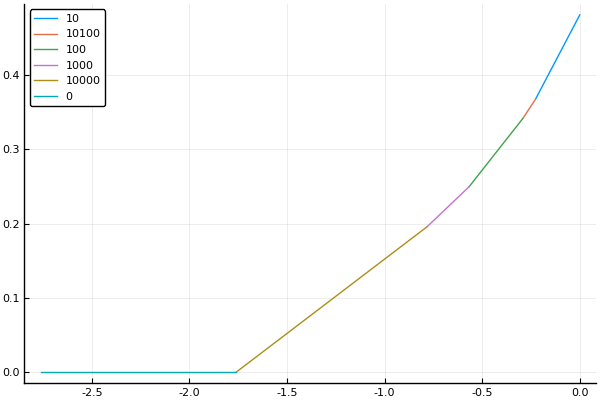

In [5]:
plot_hβ(5)

exp.(β) = [1.0, 0.796718, 0.746391, 0.566979, 0.457029, 0.171573]


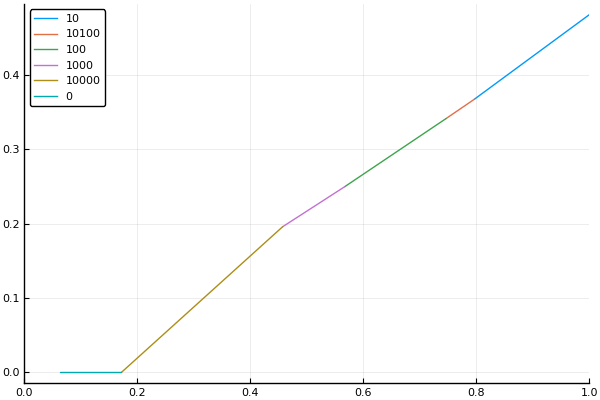

In [7]:
plot_hα(5)